# NOTE BOOK FOR DEVELOPING THE RSI STRATEGY 

## AIM TO HAVE FULL FUNCTIONALITY SIMILAR TO SMA STRATEGY


In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# HOW DOES CHANGING THE PARAMETERS ALLOW TO FIT DIFFERENT TRADING STYLES OR RISK:REWARD RATIOS?

PERIOD CHANGING:
- SHORTER = more sensitive to price changes --> more signals | best suited for faster trades maybe scalps?
- DEFAULT (14) = Balanced and works well for most cases | suited standard swing traders or mid term strategies
- LONGER (21, 30,...) = Smooths out signals --> fewer trades possibly better filtered | suited for conservative long term traders who want A setups (ideally every trade is A setup)

TAKE PROFIT AND STOP LOSS ADJUSTMENTS
- LOW VALUE = 
    - TP: quick exits with lower profit per trade
    - SL: tighter control, small losses --> avoiding large drawdowns could be easier
- HIGH VALUE =
    - TP: allows trades to breathe --> potentially higher gains
    - SL: can avoid getting stopped out too early but at the risk of bigger losses

COMMON TAKE PROFIT RANGE --> 5 - 15%

COMMON STOP LOSS RANGE --> 2 - 10%

In [2]:
#Strategy Parameters
ticker = "NVDA"
rsi_period = 14
rsi_overbought = 70
rsi_oversold = 30
take_profit_pct = 0.20
stop_loss_pct = 0.10
years = 5
initial_capital = 1



In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days = years * 365)

df_rsi_v1 = yf.download(ticker, start=start_date, end=end_date)

df_rsi_v1.columns = df_rsi_v1.columns.get_level_values(0)

C:\Users\nic\AppData\Local\Temp\ipykernel_11880\867439909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_rsi_v1 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [4]:
#compute RSI 
def compute_rsi(series, period = 14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window = period).mean()
    avg_loss = loss.rolling(window = period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_rsi_v1['RSI'] = compute_rsi(df_rsi_v1['Close'],rsi_period)


In [5]:
#defining TP/SL logic similar to SMA 
tp_sl_signals = []
in_trade = False
entry_price = 0

for i in range(len(df_rsi_v1)):
    close_price = df_rsi_v1['Close'].iloc[i]
    rsi_value = df_rsi_v1['RSI'].iloc[i]

    if not in_trade:
        if rsi_value < rsi_oversold:
            entry_price = close_price
            in_trade = True
            tp_sl_signals.append(1)
        else:
            tp_sl_signals.append(0)
    else:
        current_return = (close_price - entry_price) / entry_price
        exit_signal = rsi_value > rsi_overbought

        if current_return >= take_profit_pct or current_return <= -stop_loss_pct or exit_signal:
            in_trade = False
            tp_sl_signals.append(0)
        else:
            tp_sl_signals.append(1)

df_rsi_v1['TP_SL_Signal'] = tp_sl_signals
        
    

In [6]:
#calculating return
df_rsi_v1['Market Return'] = df_rsi_v1['Close'].pct_change()
df_rsi_v1['Strategy Return'] = df_rsi_v1['Market Return'] * df_rsi_v1['TP_SL_Signal'].shift(1).fillna(0)

df_rsi_v1['Cumulative Market Return'] = (1 + df_rsi_v1['Market Return'].fillna(0)).cumprod()
df_rsi_v1['Cumulative Strategy Return'] = (1 + df_rsi_v1['Strategy Return'].fillna(0)).cumprod()

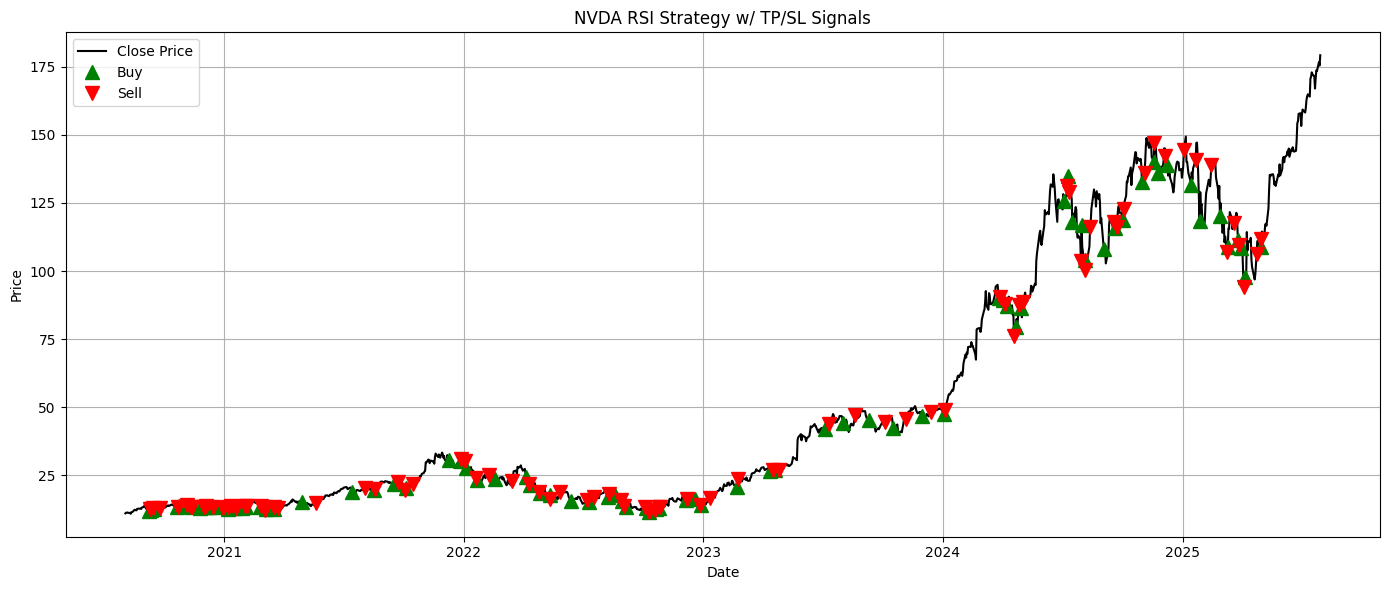

In [7]:
# plotting RSI with Entry and Exit points
plt.figure(figsize=(14,6))
plt.plot(df_rsi_v1['Close'], label = 'Close Price', color = 'black')

buy_signals = df_rsi_v1[df_rsi_v1['TP_SL_Signal'].diff() == 1]
sell_signals = df_rsi_v1[df_rsi_v1['TP_SL_Signal'].diff() == -1]

plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize = 10, color = 'green', label = 'Buy')
plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize = 10, color = 'red', label = 'Sell')
plt.title(f"{ticker} RSI Strategy w/ TP/SL Signals")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



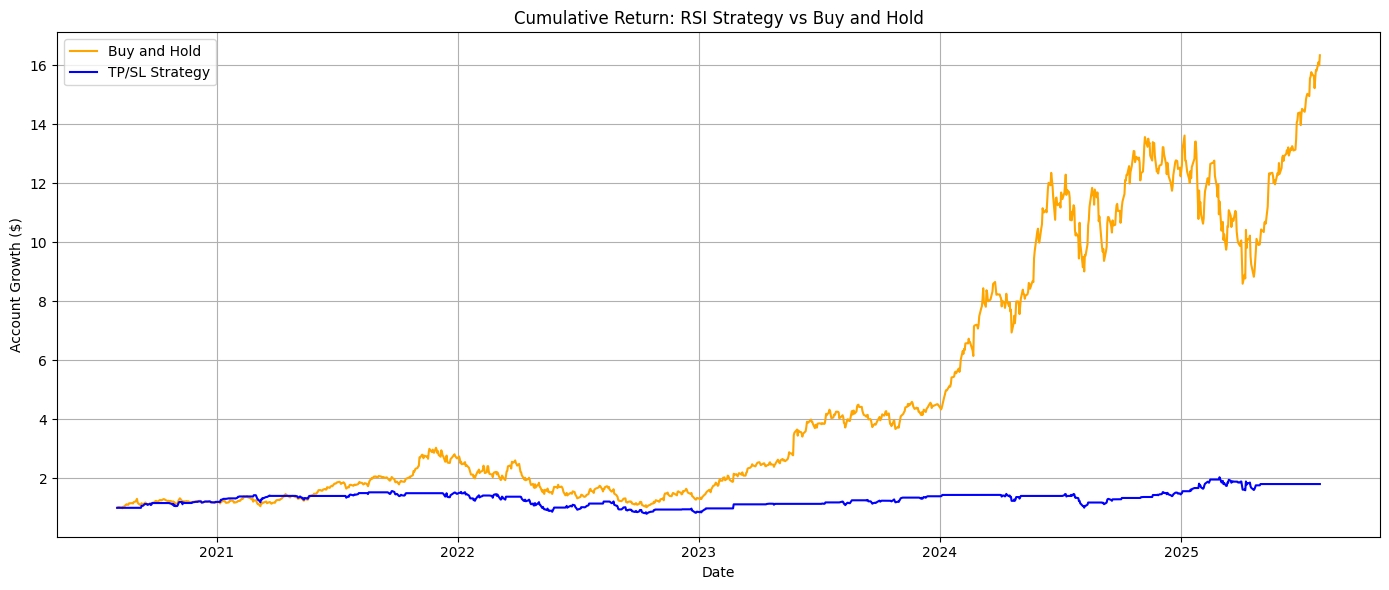

In [8]:
#plot versus simply buying and holding a stock
plt.figure(figsize=(14,6))
plt.plot(df_rsi_v1['Cumulative Market Return'], label = 'Buy and Hold', color = 'orange')
plt.plot(df_rsi_v1['Cumulative Strategy Return'], label = 'TP/SL Strategy', color = 'blue')
plt.title('Cumulative Return: RSI Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Account Growth ($)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


AFTER EXPERIMENTING WITH THE RSI PARAMETERS IT APPEARS THAT WE RARELY REACH 3 DOLLARS LET ALONE 16 DOLLARS THAT THE BUY AND HOLD STRATEGY RETURNED
- PARAMETERS CHANGED
    - LOOSENED RSI OVERBOUGH/SOLD RANGE 
    - INCREASED RSI PERIOD AND DECREASED RSI PERIOD
    - WIDENED TP/SL RANGE 

THIS ALLOWED ME TO COME TO THE REALIZATION THAT PERHAPS WE NEED MORE PARAMETERS OR SIGNALS TO SUPPLY US WITH HIGHER QUALITY ENTRIES

## OUR NEXT IMPLEMENTATIONS WILL BE SIGNALS FOR WHEN RSI CROSSES OVER SPECIFIC VALUES

FEATURES TO IMPLEMENT:
- RSI CROSSOVER SPECIFIC VALUES
- HELPS FILTER OUT NOISE FROM PROLONG OVERSOLD AND OVERBOUGHT PERIODS OF TIME
- ADD FLEXIBILITY TO COMBINE WITH SMA AND EMA STRATEGY


In [151]:
# Strategy Parameters
ticker = "NVDA"
rsi_period = 30
overbought = 70
oversold = 30
take_profit_pct = 0.10  # 
stop_loss_pct = 0.05    # 
rsi_exit_level = 50

In [152]:
# Date Range
end_date = datetime.today()
start_date = end_date - timedelta(days=365*3)

# Download Data
df_rsi_v2 = yf.download(ticker, start=start_date, end=end_date)
df_rsi_v2 = df_rsi_v2[['Close']].copy()

#Format
df_rsi_v2.columns = df_rsi_v2.columns.get_level_values(0)

C:\Users\nic\AppData\Local\Temp\ipykernel_11880\2606227401.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_rsi_v2 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [153]:
# Compute RSI --> creating a new column for the RSI Value so we can check it
delta = df_rsi_v2['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=rsi_period).mean()
avg_loss = loss.rolling(window=rsi_period).mean()
rs = avg_gain / avg_loss
df_rsi_v2['RSI'] = 100 - (100 / (1 + rs))

In [154]:
# RSI CROSS OVER SIGNALS
# Step 1: Identify buy/sell entries
buy_signal = (df_rsi_v2['RSI'].shift(1) < oversold) & (df_rsi_v2['RSI'] >= oversold)
sell_signal = (df_rsi_v2['RSI'].shift(1) > overbought) & (df_rsi_v2['RSI'] <= overbought)

# Step 2: Initialize Signal column
df_rsi_v2['Signal'] = 0
df_rsi_v2.loc[buy_signal, 'Signal'] = 1   # Long entry
df_rsi_v2.loc[sell_signal, 'Signal'] = -1  # Short entry

In [155]:
# take profit and stop loss logic
# includes long and short trade logic
rsi_exit_count = 0
tp_exit_count = 0
sl_exit_count = 0


tp_sl_signals = []
in_trade = False
entry_price = 0
position_type = 0  # 1 = long, -1 = short

for i in range(len(df_rsi_v2)):
    price = df_rsi_v2['Close'].iloc[i]
    rsi = df_rsi_v2['RSI'].iloc[i]
    signal = df_rsi_v2['Signal'].iloc[i]

    if not in_trade:
        if signal == 1:  # Long entry
            in_trade = True
            entry_price = price
            position_type = 1
            tp_sl_signals.append(position_type)
        elif signal == -1:  # Short entry
            in_trade = True
            entry_price = price
            position_type = -1
            tp_sl_signals.append(position_type)
        else:
            tp_sl_signals.append(0)
    else:
        # Long trade
        if position_type == 1:
            current_return = (price - entry_price) / entry_price
            rsi_exit = rsi > rsi_exit_level
        # Short trade
        else:
            current_return = (entry_price - price) / entry_price
            rsi_exit = rsi < rsi_exit_level

        if current_return >= take_profit_pct:
            tp_exit_count += 1
        elif current_return <= -stop_loss_pct:
            sl_exit_count += 1
        elif rsi_exit:
            rsi_exit_count += 1

        if current_return >= take_profit_pct or current_return <= -stop_loss_pct or rsi_exit:
            in_trade = False
            position_type = 0
            tp_sl_signals.append(0)
        else:
            tp_sl_signals.append(position_type)

# Final signal logic
df_rsi_v2['TP_SL_Signal'] = tp_sl_signals

In [156]:
print(f"Exited by TP: {tp_exit_count}")
print(f"Exited by SL: {sl_exit_count}")
print(f"Exited by RSI: {rsi_exit_count}")


Exited by TP: 1
Exited by SL: 10
Exited by RSI: 0


In [157]:
# Calculate Returns
df_rsi_v2['Market Return'] = df_rsi_v2['Close'].pct_change()
df_rsi_v2['Strategy Return'] = df_rsi_v2['Market Return'] * df_rsi_v2['TP_SL_Signal'].shift(1).fillna(0)
df_rsi_v2['Cumulative Market Return'] = (1 + df_rsi_v2['Market Return'].fillna(0)).cumprod()
df_rsi_v2['Cumulative Strategy Return'] = (1 + df_rsi_v2['Strategy Return']).cumprod()

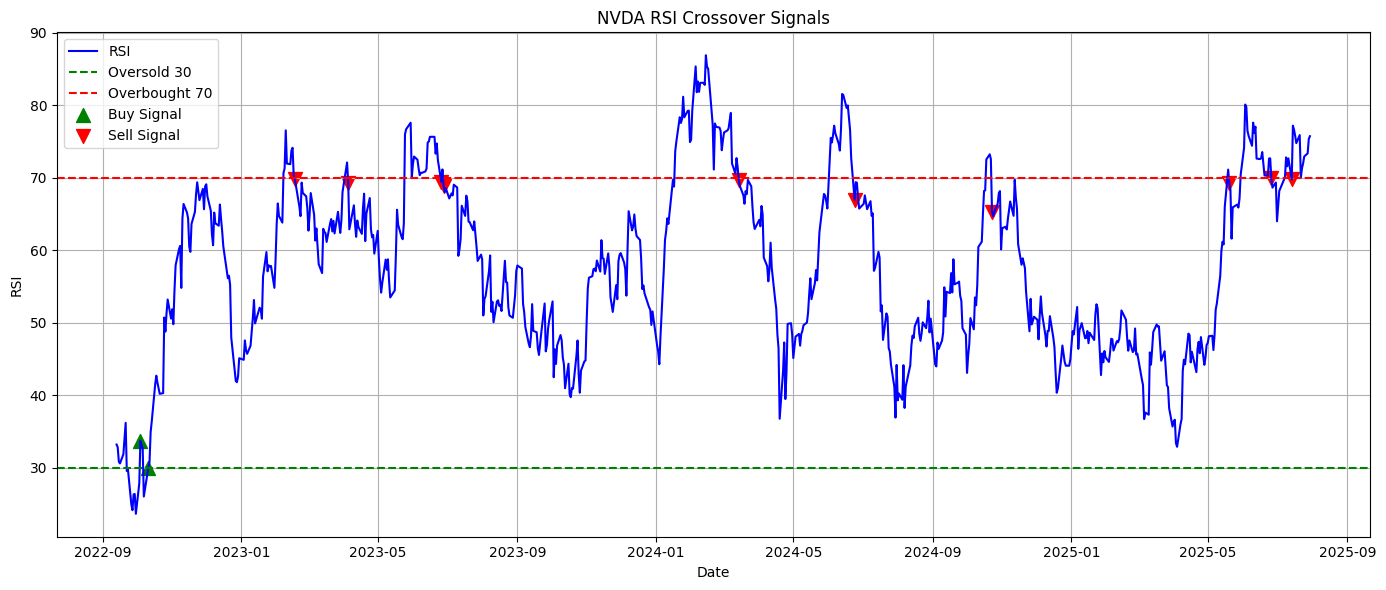

In [158]:
# Plot RSI with Signals
plt.figure(figsize=(14, 6))
plt.plot(df_rsi_v2['RSI'], label='RSI', color='blue')
plt.axhline(oversold, color='green', linestyle = '--', label=f'Oversold {oversold}')
plt.axhline(overbought, color='red', linestyle = '--', label=f'Overbought {overbought}')

plt.scatter(df_rsi_v2[df_rsi_v2['Signal'] == 1].index, 
            df_rsi_v2['RSI'][df_rsi_v2['Signal'] == 1],
            marker='^', color='green', label='Buy Signal', s=100)

plt.scatter(df_rsi_v2[df_rsi_v2['Signal'] == -1].index, 
            df_rsi_v2['RSI'][df_rsi_v2['Signal'] == -1],
            marker='v', color='red', label='Sell Signal', s=100)

plt.title(f"{ticker} RSI Crossover Signals")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

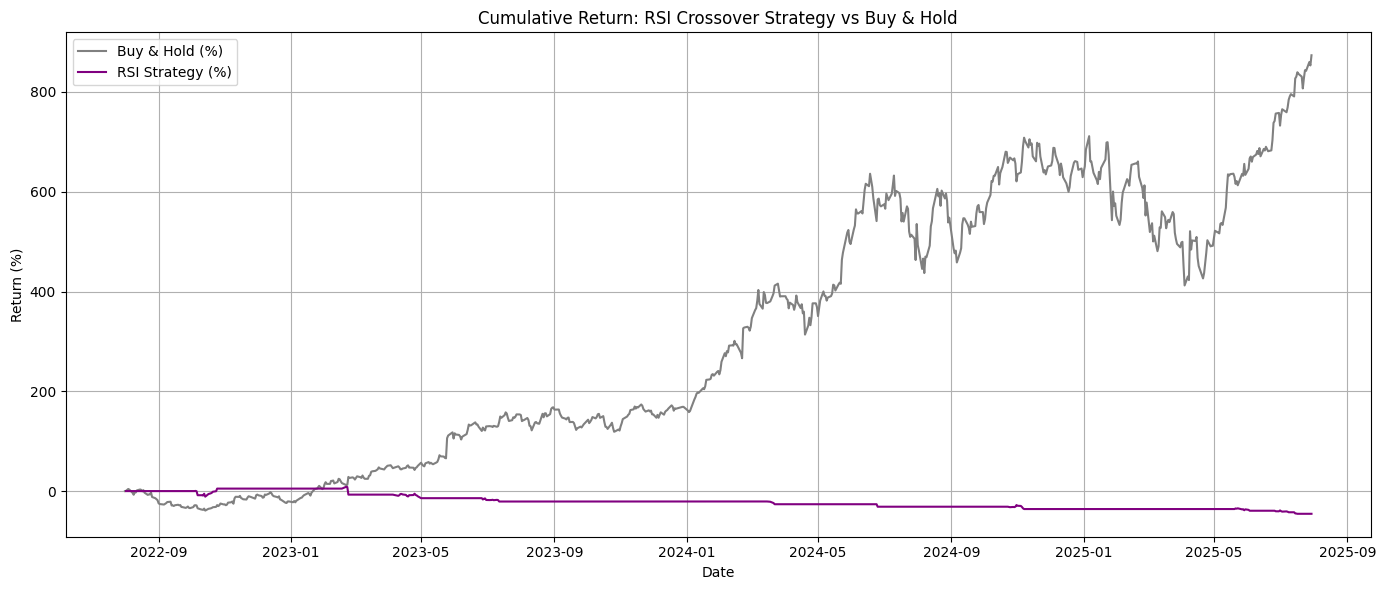

In [159]:
# Strategy versus Market Returns

plt.figure(figsize=(14, 6))
plt.plot((df_rsi_v2['Cumulative Market Return'] - 1) * 100, label='Buy & Hold (%)', color='gray')
plt.plot((df_rsi_v2['Cumulative Strategy Return'] - 1) * 100, label='RSI Strategy (%)', color='purple')
plt.title("Cumulative Return: RSI Crossover Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [160]:
df_rsi_v2['Signal'].value_counts()

Signal
 0    740
-1     10
 1      2
Name: count, dtype: int64

UPON ANALYSIS OF THE RSI STRATEGY IT APPEARS THAT WHEN NVIDIA WAS ON A VERY STRONG UPWARD TREND, RSI SIGNALS TO USE THAT "HEY SHORT OR SELL THIS BECAUSE IT IS OVERBOUGHT" WHEN IN REALITY ITS JUST A STRONG BULL RUN

RSI COULD WORK BETTER IN STOCKS THAT HAVE A NORMAL RANGE OF PRICES OR APPEARS TO GO SIDEWAYS AS THEN THE PRICE IS MORE LIKELY TO RETURN TO THE MIDDLE. 

HOW COULD RSI PERFORM IN A VOLATILE AND CHOPPY STOCK MARKET?
